In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [14]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.managed.is_last_step import RemainingSteps
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import InputFormat

In [28]:
class Feedback(BaseModel):
    grade: Literal["matched", "mismatched"] = Field(
        description="Decide if the extracted information matches the OCR text"
    )
    feedback: str = Field(
        description="If the extracted information does not match the OCR text, provide feedback on how to improve and modify it"
    )


class ExtractedInfo(BaseModel):
    company_name: str = Field(description="Name of the company")
    year_ended_date: str = Field(
        description="Year ended date of the financial statement in the format of YYYY-MM-DD"
    )
    total_current_assets: float = Field(
        description="Total current assets of the company in the year"
    )
    total_assets: float = Field(description="Total assets of the company in the year")
    total_equity_and_liabilities: float = Field(
        description="Total equity and liabilities of the company in the year"
    )


class State(TypedDict):
    file: str
    ocr_text: str
    extracted_info: ExtractedInfo
    feedback: str
    match_or_not: str
    retry_number: int

In [16]:
# ocr
doc_converter = DocumentConverter()
doc_converter.initialize_pipeline(InputFormat.PDF)

# llm
llm = ChatOpenAI(model="gpt-4o", temperature=0, verbose=True)
generator = llm.with_structured_output(ExtractedInfo)
evaluator = llm.with_structured_output(Feedback)

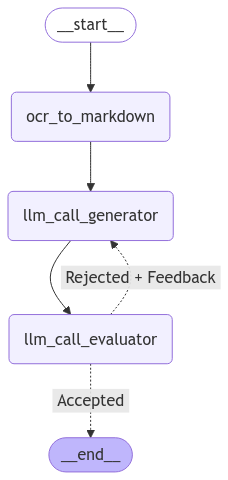

In [36]:
# nodes
def ocr_to_markdown(state: State):
    """OCR converts the image to markdown text"""
    result = doc_converter.convert(state["file"])
    result_md = result.document.export_to_markdown()
    return {"ocr_text": result_md}


def llm_call_generator(state: State):
    """LLM extracts structured information from OCR text"""
    system_prompt = """ 
    You are a helpful AI assistant that can extract structured financial information from OCR texts of company's financial statements.
    You should only extract the information from the provided OCR text, and do not make any assumptions or inferences.
    You should follow the steps to complete the task:
    1. Review the OCR text collectively to comprehend the information.
    2. Extract the following information from the OCR text:
        - Company name
        - Year ended date
        - Total current assets
        - Total assets
        - Total equity and liabilities
    3. Provide the extracted information in the structured format.
    """
    current_retry_number = state.get("retry_number")
    current_retry_number -= 1
    if state.get("feedback"):
        
        response = generator.invoke(
            [
                SystemMessage(content=system_prompt),
                HumanMessage(content=state["ocr_text"]),
                AIMessage(content=state["extracted_info"].model_dump_json()),
                AIMessage(content=state["feedback"]),
            ]
        )
    else:
        response = generator.invoke(
            [
                SystemMessage(content=system_prompt),
                HumanMessage(content=state["ocr_text"]),
            ]
        )
    return {"extracted_info": response, 'retry_number': current_retry_number}


def llm_call_evaluator(state: State):
    """LLM evaluates the extracted information"""
    system_prompt = """ 
    You are a helpful AI assistant that can verify the extracted structured financial information from OCR texts of company's financial statements.
    You should only need to verify the extracted field from the provided OCR text, and do not suggest adding other information that is not being extracted.
    You should follow the steps to complete the task:
    1. Only compare the extracted information against the original OCR texts to find mismatched places. 
    2. The extracted field name may not be completely identical to the original field name in the OCR text. These differences should not be considered as mismatched. For example, total_equity_and_liabilities is equivalent to total_liabilities_and_owners_equity.
    3. If you find mismatched places, explain why you think they are mismatched.
    4. Provide the feedback in the structured format.
    """
    response = evaluator.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=state["ocr_text"]),
            AIMessage(content=state["extracted_info"].model_dump_json()),
        ]
    )
    return {"feedback": response.feedback, "match_or_not": response.grade}


# edges
def route_extraction(state: State):
    if state["retry_number"] == 0:
        return "Accepted"
    if state["match_or_not"] == "matched":
        return "Accepted"
    elif state["match_or_not"] == "mismatched":
        return "Rejected + Feedback"


# graph
graph_builder = StateGraph(State)

# add nodes
graph_builder.add_node("ocr_to_markdown", ocr_to_markdown)
graph_builder.add_node("llm_call_generator", llm_call_generator)
graph_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# add edges
graph_builder.add_edge(START, "ocr_to_markdown")
graph_builder.add_edge("ocr_to_markdown", "llm_call_generator")
graph_builder.add_edge("llm_call_generator", "llm_call_evaluator")
graph_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_extraction,
    {"Accepted": END, "Rejected + Feedback": "llm_call_generator"},
)

workflow = graph_builder.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))

In [7]:
def doc_to_markdown(doc):
    result = doc_converter.convert(doc)
    result_md = result.document.export_to_markdown()
    return result_md

In [8]:
# downloaded from https://mbpc.tcnj.edu/wp-content/uploads/sites/148/2021/10/Sample-Financial-Statements-1.pdf
doc = "test_files/Sample-Financial-Statements-1.pdf"
md = doc_to_markdown(doc)

In [9]:
print(md)

## Sample Company

## Income Statement (Service)

For the Year Ended September 30, 2021

Service revenue

$2,750

| Operating Expenses:  Depreciation expense  Wages expenses  Supplies expenses   | 100  1,200   |       |
|--------------------------------------------------------------------------------|--------------|-------|
|                                                                                | 60           |       |
| Total operating expenses                                                       |              | 1,360 |
| Operating Income                                                               |              | 1,390 |
| Other Item:  Interest expense                                                  | 40           |       |
| Pretax income                                                                  |              | 1,350 |
| Income tax expense                                                             | 405          |       |
| Net income                          

In [37]:
test_state = workflow.invoke({"file": "test_files/Sample-Financial-Statements-1.pdf", "retry_number": 3}, )

In [39]:
print(test_state['extracted_info'].model_dump_json(indent=2))

{
  "company_name": "Sample Company",
  "year_ended_date": "2021-09-30",
  "total_current_assets": 2360.0,
  "total_assets": 13060.0,
  "total_equity_and_liabilities": 13060.0
}
